In [1]:
from functools import partial
import operator
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import (BaseEstimator, 
                          ClassifierMixin)
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import (ConvergenceWarning, 
                                UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             f1_score,
                             make_scorer,
                             precision_score, 
                             recall_score, 
                             roc_curve)
from sklearn.model_selection import (cross_val_score, 
                                     GridSearchCV,
                                     learning_curve, 
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import (make_pipeline, 
                              Pipeline)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import (LinearSVC, 
                         SVC)
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

In [2]:
data_dir = Path.cwd() / 'data'
audio_pkl = data_dir / 'audio_df.pkl'
audio_df = pd.read_pickle(audio_pkl)
audio_df.shape

(2121, 89)

In [3]:
audio_df.head(2)

,song,seg,tempo,dynamic_tempo_mean,dynamic_tempo_median,dynamic_tempo_std,dynamic_tempo_amin,dynamic_tempo_amax,pitch_0_mean,pitch_0_median,...,spectral_flatness_median,spectral_flatness_std,spectral_flatness_amin,spectral_flatness_amax,spectral_rolloff_mean,spectral_rolloff_median,spectral_rolloff_std,spectral_rolloff_amin,spectral_rolloff_amax,artist
0,21StCentury,0,117.453835,116.845143,117.453835,1.654658,112.347147,117.453835,0.427060,0.404514,...,0.030193,0.048358,0.000559,0.875394,6097.246464,6336.145020,1629.179177,2239.453125,9366.943359,RedHotChiliPeppers
1,21StCentury,1,117.453835,116.818981,117.453835,2.229267,112.347147,123.046875,0.451266,0.422953,...,0.050188,0.046202,0.001887,0.340866,6458.052616,6416.894531,953.517885,3090.014648,9334.643555,RedHotChiliPeppers


In [4]:
X = audio_df.drop(columns=['song', 'seg', 'artist'])
y = audio_df['artist'].map({'Eminem': 0, 'RedHotChiliPeppers': 1})

In [5]:
class BaselineClassifier(BaseEstimator, ClassifierMixin):
    """A classifier that always predicts the baseline class."""
    
    def __init__(self, baseline=None):
        self.baseline = baseline
    
    def fit(self, X=None, y=None):
        return
    
    def predict(self, X):
        return np.full(len(X), self.baseline)
    

EminemClassifier = BaselineClassifier(0)
RHCPClassifier = BaselineClassifier(1)

In [6]:
def cv_score(estimator, X, y, cv=5, scoring=None):
    """Return the mean score of an estimator and classifier objects X and y using cross validation."""
    
    scaler = StandardScaler()
    pipeline = Pipeline([('transformer', scaler), ('estimator', estimator)])
    cvs = cross_val_score(estimator=pipeline, 
                          X=X, 
                          y=y, 
                          cv=cv,
                          scoring=scoring)
    return cvs.mean()


def score_estimator(estimator):
    """Return dict with name of scorer as key and the score as the value for each scorer."""
    
    return {name: cv(estimator) for name, cv in zip(metric_names, cv_metrics)}


cv_X_y = partial(cv_score, X=X, y=y)
cv_accuracy = partial(cv_X_y, scoring=make_scorer(accuracy_score))
cv_f1 = partial(cv_X_y, scoring=make_scorer(f1_score))
cv_precision = partial(cv_X_y, scoring=make_scorer(precision_score))
cv_recall = partial(cv_X_y, scoring=make_scorer(recall_score))

metric_scores = [accuracy_score, f1_score, precision_score, recall_score]
metric_names = [metric.__name__ for metric in metric_scores]
cv_metrics = [cv_accuracy, cv_f1, cv_precision, cv_recall]

In [7]:
sns.set_style("darkgrid")

def plot_roc_calc_auc(estimator, X_train, X_test, y_train, y_test, *, dpi=1000):
    """Plot the ROC and return the AUC. Also save to disk as png with dpi resolution."""
    
    estimator.fit(X_train, y_train)
    y_score = estimator.predict_proba(X_test)
    false_pos, true_pos, _ = roc_curve(y_test, y_score[:,1])
    
    est_name = type(estimator).__name__
    default_params = type(estimator)().get_params().items()
    estimator_params = estimator.get_params().items()
    hyper_params = (est_p for def_p, est_p in zip(default_params, estimator_params) if def_p != est_p)
    hyper_params = (f'{arg}={val}' for arg, val in hyper_params)
    hyper_params = ', '.join(hyper_params)
    
    plt.plot(false_pos, true_pos)
    plt.title(f'ROC: {est_name}({hyper_params})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    path = data_dir / f'{est_name}.png'
    plt.savefig(path, dpi=dpi)
    
    return f'AUC: {auc(false_pos, true_pos)}'


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plot_roc_calc_auc_audio = partial(plot_roc_calc_auc, 
                                  X_train=X_train,
                                  X_test=X_test,
                                  y_train=y_train,
                                  y_test=y_test)

In [8]:
def grid_search_cv(estimator, param_grid, X, y, cv=5):
    """Return best_params_ after applying a standard scaler"""
    
    scaler = StandardScaler()
    grid = make_pipeline(scaler, GridSearchCV(estimator, param_grid=param_grid, cv=cv))
    grid.fit(X, y)
    return grid.named_steps['gridsearchcv'].best_params_


grid_cv = partial(grid_search_cv, X=X, y=y)

# Baselines

In [9]:
score_estimator(EminemClassifier)

{'accuracy_score': 0.4507302996670366,
 'f1_score': 0.0,
 'precision_score': 0.0,
 'recall_score': 0.0}

In [10]:
score_estimator(RHCPClassifier)

{'accuracy_score': 0.5492697003329634,
 'f1_score': 0.7090690390602953,
 'precision_score': 0.5492697003329634,
 'recall_score': 1.0}

# KNN

In [11]:
param_grid = {'n_neighbors': range(1, 21)}
knn_best = grid_cv(KNeighborsClassifier(), param_grid=param_grid)
knn_best

{'n_neighbors': 16}

In [12]:
score_estimator(KNeighborsClassifier(**knn_best))

{'accuracy_score': 0.822739178690344,
 'f1_score': 0.8486761616217471,
 'precision_score': 0.8045461471087944,
 'recall_score': 0.9012875536480687}

'AUC: 0.9816573348264277'

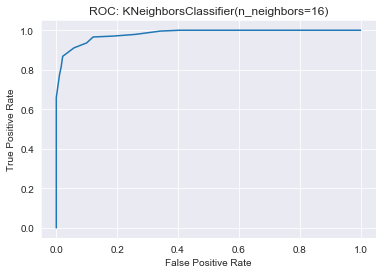

In [13]:
plot_roc_calc_auc_audio(KNeighborsClassifier(**knn_best))

# Logistic Regression

In [14]:
param_grid = {'C': [pow(10, i) for i in range(-3, 4)], 'penalty': ['l1', 'l2']}
logreg_best = grid_cv(LogisticRegression(), param_grid=param_grid)
logreg_best

{'C': 0.1, 'penalty': 'l1'}

In [15]:
score_estimator(LogisticRegression(**logreg_best))

{'accuracy_score': 0.9014739178690345,
 'f1_score': 0.9106312570853327,
 'precision_score': 0.9069227220203826,
 'recall_score': 0.9150214592274677}

'AUC: 0.9779619260918253'

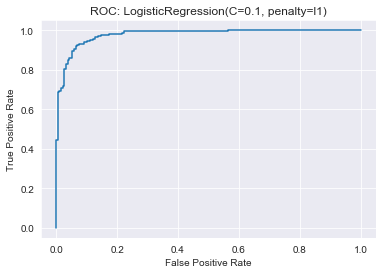

In [16]:
plot_roc_calc_auc_audio(LogisticRegression(**logreg_best))

In [17]:
logreg = LogisticRegression(**logreg_best)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
{name: score(y_test, y_pred) for name, score in zip(metric_names, metric_scores)}

{'accuracy_score': 0.9247058823529412,
 'f1_score': 0.9322033898305084,
 'precision_score': 0.9282700421940928,
 'recall_score': 0.9361702127659575}

In [18]:
series = pd.Series(logreg.coef_.ravel(), X.columns)
series[series != 0]

dynamic_tempo_amax          -0.229274
pitch_1_median              -0.040072
pitch_1_amax                 0.011711
pitch_2_std                  0.263387
pitch_2_amin                -0.027282
pitch_2_amax                 0.195790
pitch_3_amin                -0.025101
pitch_4_amax                 0.191170
pitch_5_median              -0.018956
pitch_5_std                 -0.028508
pitch_6_mean                -0.044614
pitch_6_median              -0.034533
pitch_6_amin                -0.035959
pitch_7_median              -0.000621
pitch_7_std                  0.191540
pitch_7_amax                 0.220664
pitch_8_std                 -0.134314
pitch_9_median              -0.072815
pitch_9_amax                 0.064784
pitch_11_mean                0.015716
pitch_11_std                 0.082383
pitch_11_amax                0.076592
spectral_bandwidth_median    0.811522
spectral_bandwidth_std       0.143742
spectral_bandwidth_amin     -0.336766
spectral_bandwidth_amax     -1.911472
spectral_cen

# Gaussian Naive Bayes

In [19]:
score_estimator(GaussianNB())

{'accuracy_score': 0.8382996670366261,
 'f1_score': 0.849738274346584,
 'precision_score': 0.8714689488979721,
 'recall_score': 0.832618025751073}

'AUC: 0.9234042553191489'

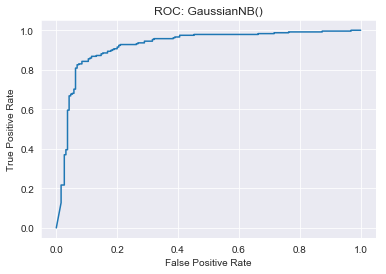

In [20]:
plot_roc_calc_auc_audio(GaussianNB())

# Linear SVC

In [21]:
score_estimator(LinearSVC())  #: Does not have predict_proba method required for AUC

{'accuracy_score': 0.8920299667036626,
 'f1_score': 0.9020202382583772,
 'precision_score': 0.8943373552900569,
 'recall_score': 0.9115879828326181}

In [22]:
score_estimator(SVC(kernel='linear'))

{'accuracy_score': 0.8830732519422864,
 'f1_score': 0.8957721981403426,
 'precision_score': 0.8782175748134291,
 'recall_score': 0.9150214592274679}

'AUC: 0.975879059350504'

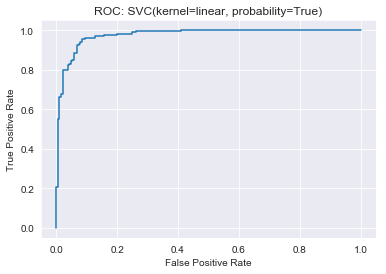

In [23]:
plot_roc_calc_auc_audio(SVC(kernel='linear', probability=True))

# SVC

In [24]:
param_grid = {'kernel': ['poly', 'rbf', 'sigmoid']}
svc_best = grid_cv(estimator=SVC(), param_grid=param_grid)
svc_best

{'kernel': 'rbf'}

In [25]:
score_estimator(SVC(**svc_best))

{'accuracy_score': 0.884496115427303,
 'f1_score': 0.8985263638275345,
 'precision_score': 0.8713291352597322,
 'recall_score': 0.9287553648068669}

'AUC: 0.9953191489361702'

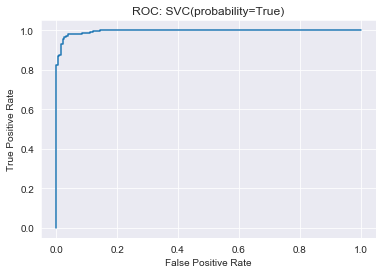

In [26]:
plot_roc_calc_auc_audio(SVC(probability=True, **svc_best))

# Decision Tree

In [27]:
param_grid = {'criterion': ['gini', 'entropy']}
dectree_best = grid_cv(DecisionTreeClassifier(), param_grid=param_grid)
dectree_best

{'criterion': 'entropy'}

In [28]:
score_estimator(DecisionTreeClassifier(**dectree_best))

{'accuracy_score': 0.8283784683684795,
 'f1_score': 0.8451956532988731,
 'precision_score': 0.8410138900917327,
 'recall_score': 0.8515021459227468}

'AUC: 0.8920492721164613'

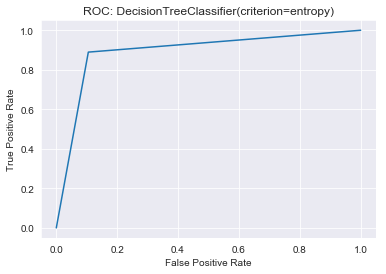

In [29]:
plot_roc_calc_auc_audio(DecisionTreeClassifier(**dectree_best))

# Random Forest

In [30]:
param_grid = {'criterion': ['gini', 'entropy']}
randforest_best = grid_cv(RandomForestClassifier(), param_grid=param_grid)
randforest_best

{'criterion': 'gini'}

In [31]:
score_estimator(RandomForestClassifier(**randforest_best))

{'accuracy_score': 0.8708290788013319,
 'f1_score': 0.8906416198891518,
 'precision_score': 0.8772851470290128,
 'recall_score': 0.8849785407725321}

'AUC: 0.9733818589025756'

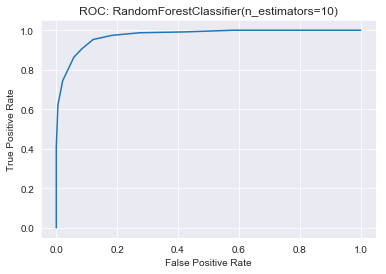

In [32]:
plot_roc_calc_auc_audio(RandomForestClassifier(**randforest_best))